#  Reading and writing image data

This is an example of how to read and write image data using `TFRecords`. 

The purpose of this is to show how, end to end, input data and write the data as a `TFRecord` file, then read the file back and display the image.

This can be useful if, for example, you want to use several models on the same input dataset. Instead of storing the image data raw, it can be preprocessed into the TFRecords format, and that can be used in all further processing and modelling.

## Import all the necessary libraries

In [1]:
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

%matplotlib inline

tf.__version__

'2.0.0-beta1'

## Utils

In [2]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Return a float_list form a float/double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Return a int64_list from a bool/enum/int/uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(feature0, feature1, feature2, feature3):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    
    # Create a dictionary mapping the feature name to 
    # the tf.Example-compatible data type
    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _float_feature(feature3),
    }
    
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

## Explore the Image data

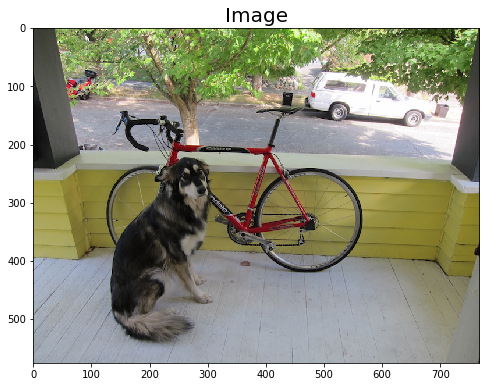

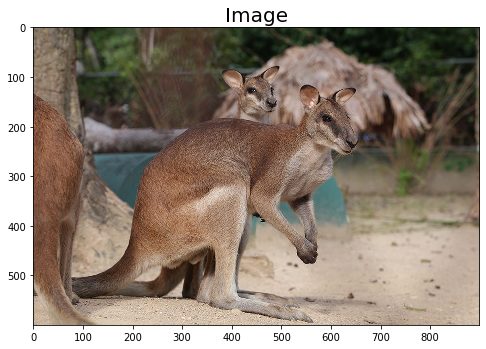

In [3]:
image_path = '../images/img/'
images = glob.glob(image_path + '*.jpg')

for fname in images:
    image = mpimg.imread(fname)
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(image)
    ax1.set_title('Image', fontsize=20)

## Write the TFRecord file

- Encode the features as types compatible with `tf.Example`.

    This stores the raw image string feature, as well as the height, width, depth, and arbitrary `label feature`.
    
    The `label feature` is used when you write the file to distinguish between the different class image, like dog and kangaroo.

In [4]:
image_labels = {
    'dog': 0,
    'kangaroo': 1,
}

In [5]:
# Read the image data into a memory buffer in binary format.
image_string = open('../images/img/dog.jpg', 'rb').read()
label = image_labels['dog']

### Create a `tf.Example` message

In [6]:
# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [7]:
image_example_proto = image_example(image_string, label)

for line in str(image_example_proto).split('\n')[:15]:
    print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 576
      }
...


### Writing the `tf.Example` to the `TFRecord` files

In [8]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecord'
with tf.io.TFRecordWriter(record_file) as writer:
    #image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [9]:
!du -sh {record_file}

196K	images.tfrecord


## Read the TFRecord file

We now have the file `images.tfrecord`. We can now iterate over the records in the file to read back what we wrote.

In [10]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecord')
raw_image_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [ ]:
for raw_image in raw_image_dataset.take(-1):
    print(repr(raw_image))
    #print(raw_image.numpy) 

### Parse the `Dataset`

In [12]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

### Recover the images from the TFRecord file:

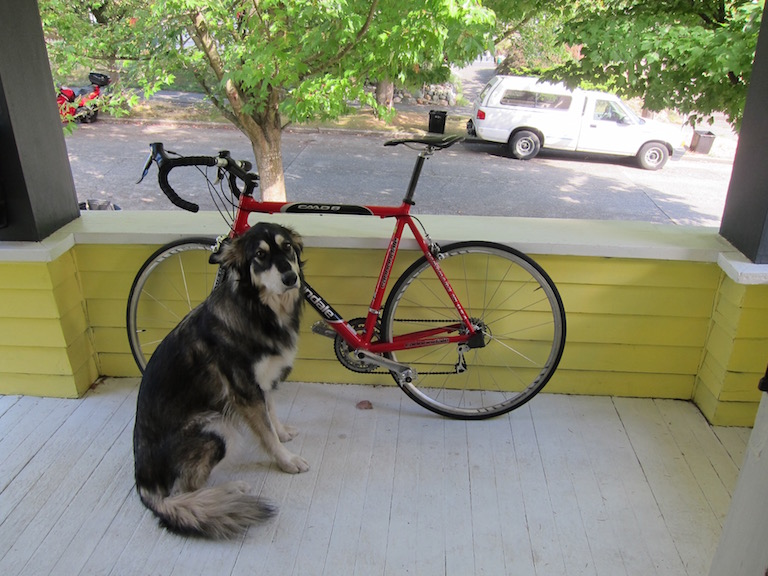

In [13]:
import IPython.display as display
for image_features in parsed_image_dataset:
    #print(repr(image_features))
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))

## Decode data into image format 

- [numpy.frombuffer](https://docs.scipy.org/doc/numpy/reference/generated/numpy.frombuffer.html#numpy-frombuffer):
    Interpret a buffer as a 1-dimensional array.

- [OpenCV - imdecode](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html):
    Reads an image from a buffer in memory.

    - Parameters:
    
        * buf: Input array or vector of bytes
        
        * flags: The same flags as in `cv::imread`, see [cv::ImreadModes](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html). 


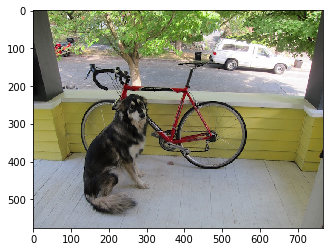

In [14]:
image_decode =  cv2.imdecode(np.frombuffer(image_raw, np.uint8), -1)
plt.imshow(cv2.cvtColor(image_decode, cv2.COLOR_BGR2RGB))